### Code for generating plot for QB vs Passcatcher draft capital on Underdog Fantasy (via the draft capital metric from @2Hats1Mike)

Import libraries

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import os
import sklearn
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

Read in underdog adp csv

In [2]:
adp = pd.read_csv('underdog_adp_8-19-24.csv')
adp.head()

,id,firstName,lastName,adp,projectedPoints,positionRank,slotName,teamName,lineupStatus,byeWeek
0,9e801ec6-ed8e-49b1-8b66-90553d7dd7e2,Christian,McCaffrey,1.3,300.6,RB1,RB,San Francisco 49ers,NaN,NaN
1,098d87b9-1fc9-4466-a7dd-7f35f697f506,CeeDee,Lamb,2.3,264.4,WR1,WR,Dallas Cowboys,NaN,NaN
2,a36d312f-0f65-4e3a-98ef-823608309b21,Tyreek,Hill,2.8,269.4,WR2,WR,Miami Dolphins,NaN,NaN
3,5a9b6074-7296-4571-94f8-6b9e803ba039,Ja'Marr,Chase,4.6,238.8,WR3,WR,Cincinnati Bengals,NaN,NaN
4,7b36b9f5-93c3-4fb7-8703-f89aa740c452,Amon-Ra,St. Brown,5.6,229.6,WR4,WR,Detroit Lions,NaN,NaN


Read in draft capital CSV

In [3]:
draft_capital = pd.read_csv('new_draft_capital.csv')
draft_capital.head()

,overall_pick_number,mean_pick_points,mean_points_above_posavg,draft_capital_adj,agg_draft_capital_adj
0,1,129,45,128.9,160
1,2,186,102,127.7,150
2,3,215,134,126.4,144
3,4,207,127,125.2,140
4,5,183,103,124.0,136


Fix non numeric values in adp column of adp df

In [4]:
adp['adp'] = pd.to_numeric(adp['adp'], errors='coerce')

Define function for assigning a draft capital number to a player based on their adp (rounded to closest number)

In [7]:
def find_nearest_value(x, df2):
    if pd.isna(x):
        return np.nan
    # Find the index of the nearest value
    nearest_idx = (np.abs(df2['overall_pick_number'] - x)).idxmin()
    return df2.loc[nearest_idx, 'agg_draft_capital_adj']

Add in draft capital information to Underdog adp df

In [8]:
adp['draft_capital'] = adp['adp'].apply(lambda x: find_nearest_value(x, draft_capital))
adp.head()

,id,firstName,lastName,adp,projectedPoints,positionRank,slotName,teamName,lineupStatus,byeWeek,draft_capital
0,9e801ec6-ed8e-49b1-8b66-90553d7dd7e2,Christian,McCaffrey,1.3,300.6,RB1,RB,San Francisco 49ers,NaN,NaN,160.0
1,098d87b9-1fc9-4466-a7dd-7f35f697f506,CeeDee,Lamb,2.3,264.4,WR1,WR,Dallas Cowboys,NaN,NaN,150.0
2,a36d312f-0f65-4e3a-98ef-823608309b21,Tyreek,Hill,2.8,269.4,WR2,WR,Miami Dolphins,NaN,NaN,144.0
3,5a9b6074-7296-4571-94f8-6b9e803ba039,Ja'Marr,Chase,4.6,238.8,WR3,WR,Cincinnati Bengals,NaN,NaN,136.0
4,7b36b9f5-93c3-4fb7-8703-f89aa740c452,Amon-Ra,St. Brown,5.6,229.6,WR4,WR,Detroit Lions,NaN,NaN,133.0


Group df to get total draft capital value for each position for each team

In [9]:
grouped = adp.groupby(['teamName', 'slotName']).agg({
    'draft_capital' : 'sum'
}).reset_index()

grouped.head()

,teamName,slotName,draft_capital
0,Arizona Cardinals,QB,56.0
1,Arizona Cardinals,RB,78.0
2,Arizona Cardinals,TE,78.0
3,Arizona Cardinals,WR,140.0
4,Atlanta Falcons,QB,18.0


Use a pivot table to make columns for each positions draft capital by team

In [10]:
pivot_df = grouped.pivot_table(index='teamName', columns='slotName', values='draft_capital', aggfunc='first').reset_index()

# Rename columns for clarity
pivot_df.columns.name = None  # Remove the name of the columns index
pivot_df.columns = ['teamName', 'QB_draft_capital', 'RB_draft_capital', 'TE_draft_capital', 'WR_draft_capital']

pivot_df.head()

,teamName,QB_draft_capital,RB_draft_capital,TE_draft_capital,WR_draft_capital
0,Arizona Cardinals,56.0,78.0,78.0,140.0
1,Atlanta Falcons,18.0,148.0,66.0,134.0
2,Baltimore Ravens,77.0,98.0,82.0,95.0
3,Buffalo Bills,87.0,83.0,73.0,136.0
4,Carolina Panthers,3.0,56.0,0.0,86.0


Add column for 'passcatcher' (WR & TE) draft capital

In [11]:
pivot_df['passcatcher_capital'] = pivot_df['WR_draft_capital'] + pivot_df['TE_draft_capital']

Adding in column for location of team logo images

In [13]:
team_abbr = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LV', 'LAC', 'LA', 'MIA', 'MIN', 'NYG', 'NYJ', 'NE', 'NO', 'PHI', 'PIT', 'SF', 'SEA', 'TB', 'TEN', 'WAS']
pivot_df['team_abbr'] = team_abbr
pivot_df.head()

,teamName,QB_draft_capital,RB_draft_capital,TE_draft_capital,WR_draft_capital,passcatcher_capital,team_abbr
0,Arizona Cardinals,56.0,78.0,78.0,140.0,218.0,ARI
1,Atlanta Falcons,18.0,148.0,66.0,134.0,200.0,ATL
2,Baltimore Ravens,77.0,98.0,82.0,95.0,177.0,BAL
3,Buffalo Bills,87.0,83.0,73.0,136.0,209.0,BUF
4,Carolina Panthers,3.0,56.0,0.0,86.0,86.0,CAR


In [14]:
pivot_df['logo_path'] = 'logos/' + pivot_df['team_abbr'] + '.tif'
pivot_df.head()

,teamName,QB_draft_capital,RB_draft_capital,TE_draft_capital,WR_draft_capital,passcatcher_capital,team_abbr,logo_path
0,Arizona Cardinals,56.0,78.0,78.0,140.0,218.0,ARI,logos/ARI.tif
1,Atlanta Falcons,18.0,148.0,66.0,134.0,200.0,ATL,logos/ATL.tif
2,Baltimore Ravens,77.0,98.0,82.0,95.0,177.0,BAL,logos/BAL.tif
3,Buffalo Bills,87.0,83.0,73.0,136.0,209.0,BUF,logos/BUF.tif
4,Carolina Panthers,3.0,56.0,0.0,86.0,86.0,CAR,logos/CAR.tif


Generate plot

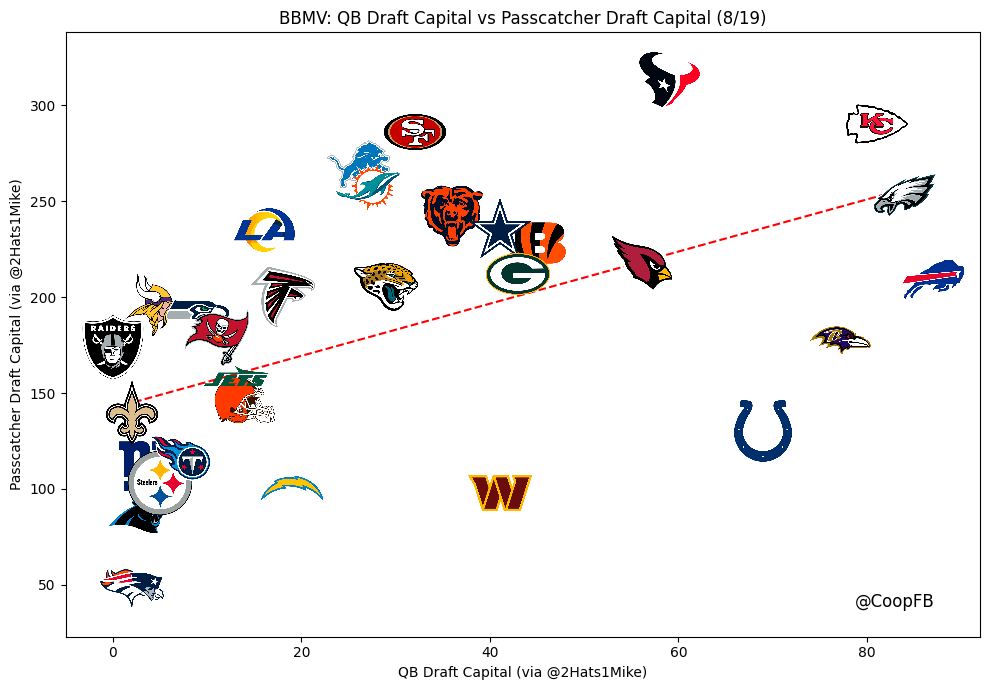

In [17]:
plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    img = plt.imread(path)
    return OffsetImage(img, zoom=0.1)


x = pivot_df['QB_draft_capital']
y = pivot_df['passcatcher_capital']
paths = pivot_df['logo_path']

coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
trend_x = np.linspace(min(x), max(x), 100)
trend_y = polynomial(trend_x)

fig, ax = plt.subplots()

for x0, y0, path in zip(x, y, paths):
   ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
   ax.add_artist(ab)


plt.xlim(min(x)-5, max(x)+5)
plt.ylim(min(y)-25, max(y)+25)

plt.plot(trend_x, trend_y, color='r', linestyle='--', label='Trend Line')
plt.text(0.95, 0.05, '@CoopFB', fontsize=12, ha='right', transform=ax.transAxes)

plt.title("BBMV: QB Draft Capital vs Passcatcher Draft Capital (8/19)")
plt.xlabel("QB Draft Capital (via @2Hats1Mike)")
plt.ylabel("Passcatcher Draft Capital (via @2Hats1Mike)")

plt.savefig('qbs_vs_passcatchers.png', dpi=300)

plt.show()